In [2]:
import os
import gc
import random
import time
import datetime
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data.sampler import SubsetRandomSampler

import dgl
from dgl.nn.pytorch import GraphConv
from dgl.dataloading import GraphDataLoader
from dgl.data import DGLDataset
from geopy import distance
import ast

In [3]:
# train_df = pd.read_csv('train_df.csv')

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
neighb = pd.read_csv('gnn_neighbor.csv')
neighb['distances'] = neighb.apply(lambda x: ast.literal_eval(x.distances), axis=1)
df_train = pd.read_csv('df_train.csv')
df_train_NN = df_train[df_train.columns[df_train.columns.str.contains('NN')]]
df_train = df_train.loc[:, ~df_train.columns.str.contains('NN')]
target_train = pd.read_csv('target_train.csv')
df_train = pd.merge(df_train, target_train, on='row_id')

df_test = pd.read_csv('df_test.csv')
df_test_NN = df_test[df_test.columns[df_test.columns.str.contains('NN')]]
df_test = df_test.loc[:, ~df_test.columns.str.contains('NN')]
target_test = pd.read_csv('target_test.csv')
df_test = pd.merge(df_test, target_test, on='row_id')
features = df_train.drop(['row_id', 'cfips', 'microbusiness_density', 'active'], axis=1).columns.tolist()

In [6]:
# df_train.describe()
df_train['cfips'] = df_train['cfips'].apply(lambda x: neighb.loc[neighb['original_cfips'] == x, 'cfips'].values[0])
df_test['cfips'] = df_test['cfips'].apply(lambda x: neighb.loc[neighb['original_cfips'] == x, 'cfips'].values[0])

In [7]:
neighb

,Unnamed: 0,cfips,neighbors,name,lng,lat,distances,original_cfips
0,0,0,"[447, 2260, 2523, 2601]",Autauga,-86.642900,32.535142,"[230, 752, 814, 481]",1001
1,1,1,"[1910, 302, 2828, 539, 1752]",Baldwin,-87.722745,30.727825,"[529, 1130, 701, 4255, 1025]",1003
2,2,2,"[1955, 648, 2164, 2793, 1927, 1395, 157, 1553,...",Barbour,-85.391068,31.870090,"[575, 630, 686, 563, 555, 247, 362, 630, 552, ...",1005
3,3,3,"[614, 803, 3051, 2860, 178, 470]",Bibb,-87.126814,32.998376,"[543, 770, 862, 375, 386, 326]",1007
4,4,4,"[2695, 2526]",Blount,-86.567006,33.980871,"[731, 785]",1009
...,...,...,...,...,...,...,...,...
3081,3081,3081,"[2968, 2834, 600]",Sweetwater,-108.879388,41.659762,"[1608, 1615, 1094]",56037
3082,3082,3082,"[286, 3079, 2205, 290, 1185, 1727, 2372, 2482,...",Teton,-110.589698,43.934564,"[377, 193, 378, 491, 1748, 489, 689, 1369, 185...",56039
3083,3083,3083,"[3042, 2184, 1932]",Uinta,-110.547405,41.287497,"[1158, 660, 1832]",56041
3084,3084,3084,"[2048, 577, 2578, 1942, 2175, 2869, 2301, 2950...",Washakie,-107.682315,43.904378,"[1333, 273, 1186, 1486, 498, 1658, 1545, 1404,...",56043


In [8]:
class GraphDataset(DGLDataset):
    def __init__(self, edges, properties, features, train=True):
        self.edges = edges
        self.properties = properties
        self.features = features
        self.train = train
        super().__init__(name="microbussiness")

    def process(self):
        self.graphs = []
        self.labels = []

        for index, group in self.properties.groupby('idx'):
            filtered_edges = self.edges[self.edges['cfips'].isin(group['cfips'])]

            if filtered_edges.empty:
                continue

            src = []
            dst = []
            w = []

            for _, row in filtered_edges.iterrows():
                neighbours = ast.literal_eval(row['neighbors'])
                distances = row['distances']

                for neighbor, distance in zip(neighbours, distances):
                    if neighbor in group['cfips'].values:
                        src.append(row['cfips'])
                        dst.append(neighbor)
                        w.append(distance)

            if len(w) == 0:
                continue

            w = np.array(w)
            min_w = np.min(w)
            max_w = np.max(w)
            w = (w - min_w) / (max_w - min_w)

            node_id_mapping = {node_id: i for i, node_id in enumerate(group['cfips'])}
            src = [node_id_mapping[x] for x in src]
            dst = [node_id_mapping[x] for x in dst]

            g = dgl.graph((src, dst), num_nodes=len(group))
            g.ndata['x'] = torch.tensor(group[self.features].values, dtype=torch.float) # node feature
            g.edata['w'] = torch.tensor(w, dtype=torch.float)  # scalar integer feature
            g = dgl.add_self_loop(g)
            self.graphs.append(g)
            if self.train:
                self.labels.append(torch.tensor(group["target"].values, dtype=torch.float))

    def __getitem__(self, i):
        if self.train:
            return self.graphs[i].to(device), self.labels[i].to(device)
        else:
            return self.graphs[i].to(device)

    def __len__(self):
        return len(self.graphs)


In [9]:
train_graph_dataset = GraphDataset(edges=neighb, properties=df_train, features=features)
val_graph_dataset = GraphDataset(edges=neighb, properties=df_test, features=features,)

In [10]:
class GNN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GNN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.convh = nn.ModuleList([GraphConv(h_feats, h_feats) for _ in range(20)])
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        for c in self.convh:
            h = c(g, h)
            h = F.relu(h)
        h = self.conv2(g, h)
        h = torch.tanh(h)
        return h

In [11]:
# import torch
# from torchviz import make_dot
# from dgl.nn import GraphConv
# import torch.nn as nn
# import torch.nn.functional as F
# import dgl

# # Your GGN class
# class GGN(nn.Module):
#     def __init__(self, in_feats, h_feats, num_classes):
#         super(GGN, self).__init__()
#         self.conv1 = GraphConv(in_feats, h_feats)
#         self.convh = nn.ModuleList([GraphConv(h_feats, h_feats) for _ in range(20)])
#         self.conv2 = GraphConv(h_feats, num_classes)

#     def forward(self, g, in_feat):
#         h = self.conv1(g, in_feat)
#         h = F.relu(h)
#         for c in self.convh:
#             h = c(g, h)
#             h = F.relu(h)
#         h = self.conv2(g, h)
#         h = torch.tanh(h)
#         return h


Epoch: 0001 train_loss: 0.9501 val_loss: 0.8958
Epoch: 0002 train_loss: 0.9505 val_loss: 0.8585
Epoch: 0003 train_loss: 0.9328 val_loss: 0.9096
Epoch: 0004 train_loss: 0.9405 val_loss: 0.8742
Epoch: 0005 train_loss: 0.9465 val_loss: 0.9181
Epoch: 0006 train_loss: 0.9519 val_loss: 0.9886
Epoch: 0007 train_loss: 0.9496 val_loss: 0.9338
Epoch: 0008 train_loss: 0.9574 val_loss: 0.8910
Epoch 00008: reducing learning rate of group 0 to 2.5000e-03.
Epoch: 0009 train_loss: 0.9419 val_loss: 0.9432
Epoch: 0010 train_loss: 0.9392 val_loss: 0.9066
Epoch: 0011 train_loss: 0.9372 val_loss: 0.8498
Epoch: 0012 train_loss: 0.9326 val_loss: 0.8743
Epoch: 0013 train_loss: 0.9356 val_loss: 0.8965
Epoch: 0014 train_loss: 0.9294 val_loss: 0.8550
Epoch: 0015 train_loss: 0.9296 val_loss: 0.8287
Epoch: 0016 train_loss: 0.9216 val_loss: 0.8181
Epoch: 0017 train_loss: 0.9266 val_loss: 0.8641
Epoch: 0018 train_loss: 0.9318 val_loss: 0.8620
Epoch: 0019 train_loss: 0.9368 val_loss: 0.8642
Epoch: 0020 train_loss: 0.

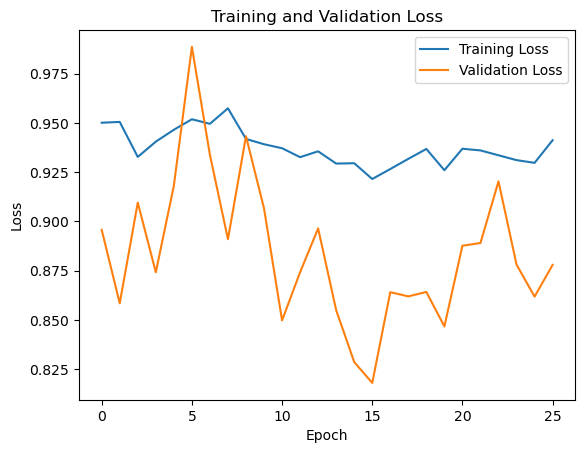

In [13]:
def smape_loss(output, target):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE) between output and target.
    """
    return torch.mean(torch.abs(output - target) / (torch.abs(output) + torch.abs(target) + 1e-8))

from torch.optim.lr_scheduler import ReduceLROnPlateau
from dgl.dataloading import GraphDataLoader

def train(model, train_loader, val_loader, num_epochs, optimizer, criterion, patience=10):
    best_val_loss = float('inf')
    best_model = None
    counter = 0
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for i, (g, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(g, g.ndata['x'])
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss = evaluate(model, val_loader, criterion)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print('Epoch: {:04d}'.format(epoch+1),
              'train_loss: {:.4f}'.format(train_loss),
              'val_loss: {:.4f}'.format(val_loss))
        
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping...")
                break
    
    model.load_state_dict(best_model)
    return train_losses, val_losses

def evaluate(model, loader, criterion):
    model.eval()
    loss = 0.0
    with torch.no_grad():
        for i, (g, labels) in enumerate(loader):
            output = model(g, g.ndata['x'])
            loss += criterion(output, labels).item()
    
    return loss / len(loader)

model = GNN(in_feats=len(features), h_feats=64, num_classes=1).to(device)
train_loader = GraphDataLoader(train_graph_dataset, batch_size=1, shuffle=False)
val_loader = GraphDataLoader(val_graph_dataset, batch_size=1, shuffle=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = smape_loss

import matplotlib.pyplot as plt

# Call the train function and get the train and validation losses
train_losses, val_losses = train(model, train_loader, val_loader, num_epochs=50, optimizer=optimizer, criterion=criterion, patience=10)

# Create a line plot
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# Customize the plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Save the plot to a file
plt.savefig('training_validation_loss.png')

# Display the plot
plt.show()


In [363]:
# def predict(model, dataset, df):
#     model.eval()
#     pred = []

#     with torch.no_grad():
#         for i, g in enumerate(dataset):            
#             y = model(g, g.ndata['x'])
#             y = y.squeeze(-1)
#             pred.append(y.to('cpu').detach().numpy())
#         pred = np.array([p for l in pred for p in l])
#         prev_m = df.loc[df['dcount'] == dcount, 'microbusiness_density'].tolist()

#     return np.array(pred)

# # Prepare the test dataset
# # temp_df, features = get_data(df, ts=min_dcount, lags=lags, train=False)
# test_graph_dataset = GraphDataset(edges=neighb, properties=df_test, features=features, train=False)

# # Get test predictions
# test_predictions = predict(model, test_graph_dataset, df)

In [ ]:
test_predictions

array([-0.99999964, -1.        , -1.        , ...,  0.01218438,
       -1.        , -1.        ], dtype=float32)